### Calculate the Word Mover's Distance between two sentences

In [1]:
import gensim.downloader as api
import glob
import sys
import os
import pandas as pd

from tqdm import tqdm

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

### Read demographic groups' sentences

In [2]:
input_path = AbsolutePathBuilder.get_path(
    f"04_youtube_scored",
    filepaths="../../../../config/filepaths.yaml"
)

df_data_desc = pd.read_csv(
    AbsolutePathBuilder.get_path(
        "00_youtube_data_description",
        filepaths="../../../../config/filepaths.yaml"
    )
)

df_data_desc["group"] = df_data_desc.group.apply(lambda s: s.split()[0])
group_urls = df_data_desc[df_data_desc.group == "White"]    
filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]

dfs = []
count = 0
for file in tqdm(filenames):
    try:
        dfs.append(pd.read_csv(os.path.join(input_path, file)))
    except:
        count += 1

df_white = pd.concat(dfs).reset_index(drop=True)
print(f"There was {count} reading errors")

group_urls = df_data_desc[df_data_desc.group == "Black"]    
filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]

dfs = []
count = 0
for file in tqdm(filenames):
    try:
        dfs.append(pd.read_csv(os.path.join(input_path, file)))
    except:
        count += 1

df_black = pd.concat(dfs).reset_index(drop=True)
print(f"There was {count} reading errors")

100%|██████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 906.95it/s]


There was 1 reading errors


100%|██████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 874.81it/s]

There was 0 reading errors


---
### Load embedding model

In [3]:
# embedding_model = api.load("glove-wiki-gigaword-50")
embedding_model = api.load("word2vec-google-news-300")

In [13]:
df_white = df_white.iloc[:100]
df_black = df_black.iloc[:100]

In [14]:
import numpy as np

data = []
distances = []
for _, row_white in tqdm(df_white.iterrows(), total=df_white.shape[0]):

    closest_row_black = None
    closest_dist = np.inf
    for _, row_black in df_black.iterrows():
        cur_distance = embedding_model.wmdistance(row_white.text, row_black.text)

        if(cur_distance < closest_dist):
            closest_dist = cur_distance
            closest_row_black = row_black

    closest_row_black.index = [f"{name}_black" for name in closest_row_black.index]
    concatenated_row = pd.concat([closest_row_black, row_white])
    
    data.append(concatenated_row)
    distances.append(closest_dist)

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.74it/s]


In [15]:
df_wmd = pd.DataFrame(data)
df_wmd["wmd"] = distances

df_wmd = df_wmd.reset_index(drop=True)

In [19]:
output_path = AbsolutePathBuilder.get_path(
    f"07_word_mover_distance",
    filepaths="../../../../config/filepaths.yaml"
)

df_wmd.to_csv(os.path.join(output_path, "youtube_wmd.csv"), index=False)

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


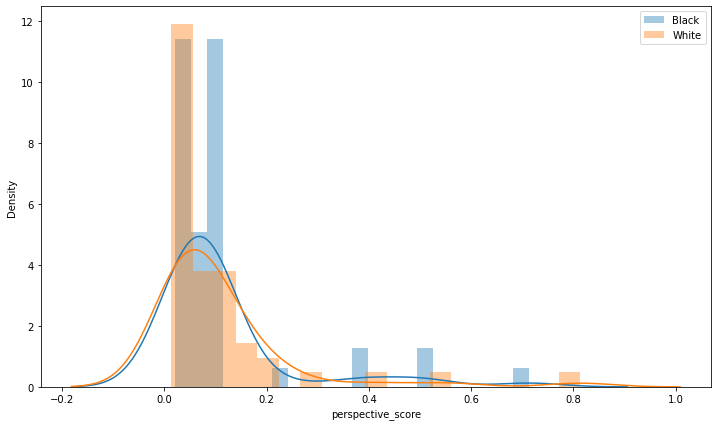

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,7))

sns.distplot(df_wmd.perspective_score_black, label="Black")
sns.distplot(df_wmd.perspective_score, label="White")

plt.legend()
plt.show()

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


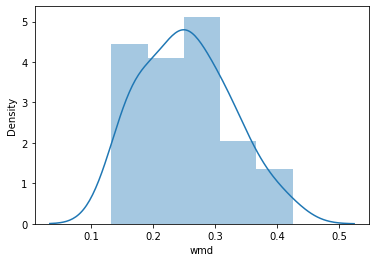

In [18]:
sns.distplot(df_wmd.wmd)
plt.title("")
plt.show()